<a href="https://colab.research.google.com/github/apreda99-star/playwright-test/blob/main/visual_product_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📦 Step 1: Importazione Librerie

Importiamo tutte le librerie necessarie per il progetto.

In [4]:
from google.colab import files
uploaded = files.upload()  # Seleziona il file dal tuo PC
MODEL_PATH = "resnet50_places365.pth.tar"

Saving resnet50_places365.pth.tar to resnet50_places365.pth.tar


In [1]:
# Librerie principali
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilità
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

print("✓ Librerie importate con successo!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA disponibile: {torch.cuda.is_available()}")

✓ Librerie importate con successo!
✓ PyTorch version: 2.9.0+cu126
✓ CUDA disponibile: True


## ⚙️ Step 2: Configurazione Parametri

Definiamo tutti i parametri dell'esperimento.

**Parametri principali:**
- `MODEL_PATH`: Path al modello pre-addestrato
- `DATASET_PATH`: Path al dataset Places365
- `BATCH_SIZE`: Numero di immagini per batch
- `NUM_EPOCHS`: Numero di epoche per il fine-tuning
- `LEARNING_RATE`: Tasso di apprendimento

In [3]:
# Path al modello
# Per Google Colab (dopo aver eseguito il download):
MODEL_PATH = "resnet50_places365.pth.tar"

# Per uso locale su Windows (decommenta se usi VS Code):
# MODEL_PATH = r"C:\Users\preda\Downloads\resnet50_places365.pth.tar"

# Path al dataset
DATASET_PATH = "places365_standard"  # cartella con sottocartelle train/val

# Parametri di training
BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 1e-4
NUM_WORKERS = 2  # Ridotto per Colab (usa 4 se hai GPU locale)

# Device (GPU o CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Stampa configurazione
print("=" * 60)
print("CONFIGURAZIONE ESPERIMENTO")
print("=" * 60)
print(f"Device: {DEVICE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epoche fine-tuning: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Num workers: {NUM_WORKERS}")
print("=" * 60)

CONFIGURAZIONE ESPERIMENTO
Device: cuda
Batch size: 32
Epoche fine-tuning: 3
Learning rate: 0.0001
Num workers: 2


## 🔧 Step 3: Caricamento Modello Pre-addestrato

Carichiamo ResNet50 con i pesi pre-addestrati su Places365.

**Nota:** Se non hai il file, scaricalo da:
- URL: http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar

In [20]:
# @title Default title text
# SOLO PER GOOGLE COLAB - Scarica il dataset
# Decommenta le righe seguenti se usi Colab:


# Download validation set (più piccolo, solo per testing)
!wget http://data.csail.mit.edu/places/places365/val_256.tar
!tar -xf val_256.tar
!mkdir -p places365_standard
# Rinomina val_256 in val se necessario
!mv val_256 places365_standard/val 2>/dev/null || mv val places365_standard/val 2>/dev/null || echo "Dataset già presente"
!ls -la places365_standard/val/ | head -20
print("✓ Validation set scaricato e estratto!")
#Verifica esistenza del modello
if not os.path.exists(MODEL_PATH):
    print(f"⚠ ATTENZIONE: File {MODEL_PATH} non trovato!")
    print(f"Scaricalo da: http://places2.csail.mit.edu/models_places365/")
    print(f"URL diretto: http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar")
else:
    # Carica checkpoint
    print(f"Caricamento checkpoint da {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location="cpu")

    # Crea modello ResNet50 con 365 classi (Places365)
    model = models.resnet50(num_classes=365)

    # Rimuovi il prefisso "module." dai nomi dei layer
    state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
    model.load_state_dict(state_dict)

    # Sposta il modello sul device
    model = model.to(DEVICE)

    print(f"✓ Modello caricato con successo!")
    print(f"✓ Numero di classi: 365 (Places365)")
    print(f"✓ Device: {DEVICE}")

--2025-11-30 23:15:01--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.csail.mit.edu/places/places365/val_256.tar [following]
--2025-11-30 23:15:02--  https://data.csail.mit.edu/places/places365/val_256.tar
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/x-tar]
Saving to: ‘val_256.tar.2’

val_256.tar.2       100%[===================>] 500.83M  49.7MB/s    in 10s     

2025-11-30 23:15:13 (48.3 MB/s) - ‘val_256.tar.2’ saved [525158400/525158400]

total 562252
drwxrwsr-x 3 21627 20681 1859584 Nov 30 23:15 .
drwxr-xr-x 3 root  root     4096 Nov 30 23:04 ..
-rw-rw-r-- 1 21627 20681   20469 May 16  2016 Places365_val_000000

## 📁 Step 4: Preparazione Dataset

Prepariamo il dataset Places365 con le trasformazioni appropriate.

**Trasformazioni applicate:**
1. Resize a 256x256
2. Center crop a 224x224
3. Conversione a Tensor
4. Normalizzazione (mean e std di ImageNet)

In [27]:
# Trasformazioni per le immagini
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Path ai dataset
val_path = os.path.join(DATASET_PATH, "val") # Corretto per puntare direttamente alla cartella 'val'
train_path = os.path.join(DATASET_PATH, "train") # Mantiene il path originale per il training set

print(f"Path validation: {val_path}")
print(f"Path training: {train_path}")

# Verifica esistenza
if os.path.exists(val_path):
    print(f"✓ Trovata cartella validation")
    # Conta le sottocartelle (classi) se esiste
    if os.path.isdir(val_path):
        subdirs = [d for d in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, d))]
        # Controlla se la lista di subdirs è vuota, il che indicherebbe che le immagini sono direttamente nella cartella
        if not subdirs:
            print(f"✓ Nessuna sottocartella di classe trovata direttamente in {val_path}. Le immagini dovrebbero essere qui.")
        else:
            print(f"✓ Numero di classi trovate: {len(subdirs)}")
else:
    print(f"⚠ Cartella validation non trovata. Verifica la struttura dei file.")

if os.path.exists(train_path):
    print(f"✓ Trovata cartella training")
else:
    print(f"⚠ Cartella training non trovata (userò validation set per il training)")

Path validation: places365_standard/val
Path training: places365_standard/train
✓ Trovata cartella validation
✓ Numero di classi trovate: 1
⚠ Cartella training non trovata (userò validation set per il training)


In [22]:
# Carica il validation set
if not os.path.exists(val_path):
    print(f"⚠ ATTENZIONE: Cartella {val_path} non trovata!")
    print(f"Scarica il dataset Places365 da: http://places2.csail.mit.edu/download.html")
else:
    print(f"Caricamento validation set da {val_path}...")
    valset = datasets.ImageFolder(val_path, transform=transform)
    valloader = DataLoader(
        valset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"✓ Validation set caricato!")
    print(f"✓ Numero di immagini: {len(valset)}")
    print(f"✓ Numero di classi: {len(valset.classes)}")
    print(f"✓ Numero di batch: {len(valloader)}")

Caricamento validation set da places365_standard/val...
✓ Validation set caricato!
✓ Numero di immagini: 36500
✓ Numero di classi: 1
✓ Numero di batch: 1141


In [23]:
# Carica il training set
if os.path.exists(train_path):
    print(f"Caricamento training set da {train_path}...")
    trainset = datasets.ImageFolder(train_path, transform=transform)
    trainloader = DataLoader(
        trainset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f"✓ Training set caricato!")
    print(f"✓ Numero di immagini: {len(trainset)}")
else:
    print(f"⚠ Training set non trovato. Userò il validation set per il fine-tuning (non ideale).")
    trainloader = valloader
    trainset = valset

⚠ Training set non trovato. Userò il validation set per il fine-tuning (non ideale).


## 📊 Step 5: Valutazione Iniziale (Prima del Fine-Tuning)

Calcoliamo la **loss** e l'**accuracy** del modello pre-addestrato sul validation set, **senza** fare alcun fine-tuning.

Questo ci servirà come baseline per confrontare i risultati dopo il fine-tuning.

In [24]:
# Funzione di loss
criterion = nn.CrossEntropyLoss()

# Modalità evaluation (disabilita dropout, batch norm, ecc.)
model.eval()

total_loss = 0.0
correct = 0
total = 0

print("Valutazione modello PRE-ADDESTRATO in corso...")
start_time = time.time()

# Disabilita il calcolo dei gradienti per velocizzare
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(valloader, desc="Evaluating")):
        # Sposta i dati sul device (GPU/CPU)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumula statistiche
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

eval_time = time.time() - start_time
loss_before = total_loss / len(valset)
accuracy_before = 100.0 * correct / total

print(f"\n{'='*60}")
print("RISULTATI INIZIALI (modello pre-addestrato)")
print(f"{'='*60}")
print(f"✓ Tempo di valutazione: {eval_time:.2f} secondi")
print(f"✓ Loss iniziale: {loss_before:.4f}")
print(f"✓ Accuracy iniziale: {accuracy_before:.2f}%")
print(f"✓ Immagini corrette: {correct}/{total}")
print(f"{'='*60}")

Valutazione modello PRE-ADDESTRATO in corso...


Evaluating: 100%|██████████| 1141/1141 [01:49<00:00, 10.45it/s]


RISULTATI INIZIALI (modello pre-addestrato)
✓ Tempo di valutazione: 109.22 secondi
✓ Loss iniziale: 14.2755
✓ Accuracy iniziale: 0.28%
✓ Immagini corrette: 101/36500


## 🎓 Step 6: Configurazione Fine-Tuning

Prepariamo il modello per il fine-tuning.

**Due strategie possibili:**
1. **Fine-tuning solo ultimo layer** (più veloce, meno rischi di overfitting)
2. **Fine-tuning completo** (più lento, potenzialmente migliori risultati)

Di default usiamo la strategia 1 (solo ultimo layer).

In [25]:
# STRATEGIA 1: Fine-tuning solo ultimo layer (fc)
print("Configurazione: Fine-tuning solo ultimo layer (fc)")

# Congela tutti i layer
for param in model.parameters():
    param.requires_grad = False

# Sblocca solo l'ultimo layer
for param in model.fc.parameters():
    param.requires_grad = True

# Conta i parametri trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"✓ Parametri trainable: {trainable_params:,}")
print(f"✓ Parametri totali: {total_params:,}")
print(f"✓ Percentuale trainable: {100.0 * trainable_params / total_params:.2f}%")

Configurazione: Fine-tuning solo ultimo layer (fc)
✓ Parametri trainable: 747,885
✓ Parametri totali: 24,255,917
✓ Percentuale trainable: 3.08%


In [29]:
# Optimizer (Adam)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)

# Scheduler per ridurre automaticamente il learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # Monitora la loss (vogliamo minimizzarla)
    factor=0.5,      # Riduci LR del 50%
    patience=1       # Aspetta 1 epoca prima di ridurre
    # verbose=True  # Rimosso, non più supportato in alcune versioni di PyTorch
)

print("✓ Optimizer configurato: Adam")
print(f"✓ Learning rate iniziale: {LEARNING_RATE}")
print("✓ Scheduler configurato: ReduceLROnPlateau")

✓ Optimizer configurato: Adam
✓ Learning rate iniziale: 0.0001
✓ Scheduler configurato: ReduceLROnPlateau


## 🚀 Step 7: Training (Fine-Tuning)

Eseguiamo il fine-tuning del modello per `NUM_EPOCHS` epoche.

**Cosa succede in ogni epoca:**
1. Il modello processa tutti i batch del training set
2. Per ogni batch: forward pass → calcolo loss → backward pass → aggiornamento pesi
3. Alla fine dell'epoca: calcolo loss e accuracy medie
4. Il scheduler aggiusta il learning rate se necessario

In [30]:
# Modalità training (abilita dropout, batch norm, ecc.)
model.train()

# Liste per salvare le metriche
training_losses = []
training_accuracies = []

print(f"\nInizio fine-tuning per {NUM_EPOCHS} epoche...\n")

for epoch in range(NUM_EPOCHS):
    print(f"{'='*60}")
    print(f"Epoca {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    epoch_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}")):
        # Sposta i dati sul device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Azzera i gradienti
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumula statistiche
        epoch_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calcola metriche dell'epoca
    epoch_time = time.time() - start_time
    avg_loss = epoch_loss / len(trainset)
    accuracy = 100.0 * correct / total

    # Salva metriche
    training_losses.append(avg_loss)
    training_accuracies.append(accuracy)

    # Stampa risultati epoca
    print(f"\nRisultati Epoca {epoch+1}:")
    print(f"  • Tempo: {epoch_time:.2f}s")
    print(f"  • Loss: {avg_loss:.4f}")
    print(f"  • Accuracy: {accuracy:.2f}%")
    print(f"  • Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Aggiorna learning rate con lo scheduler
    scheduler.step(avg_loss)
    print()

print(f"{'='*60}")
print("✓ Fine-tuning completato!")
print(f"{'='*60}")


Inizio fine-tuning per 3 epoche...

Epoca 1/3


Epoch 1: 100%|██████████| 1141/1141 [01:56<00:00,  9.78it/s]



Risultati Epoca 1:
  • Tempo: 116.65s
  • Loss: 1.1730
  • Accuracy: 81.70%
  • Learning rate: 0.000100

Epoca 2/3


Epoch 2: 100%|██████████| 1141/1141 [01:54<00:00,  9.97it/s]



Risultati Epoca 2:
  • Tempo: 114.50s
  • Loss: 0.0065
  • Accuracy: 99.95%
  • Learning rate: 0.000100

Epoca 3/3


Epoch 3: 100%|██████████| 1141/1141 [01:53<00:00, 10.03it/s]


Risultati Epoca 3:
  • Tempo: 113.76s
  • Loss: 0.0019
  • Accuracy: 99.99%
  • Learning rate: 0.000100

✓ Fine-tuning completato!


## 📊 Step 8: Valutazione Finale (Dopo Fine-Tuning)

Ricalcoliamo la **loss** e l'**accuracy** del modello dopo il fine-tuning.

Questo ci permetterà di confrontare i risultati con quelli ottenuti prima del fine-tuning.

In [31]:
# Modalità evaluation
model.eval()

total_loss = 0.0
correct = 0
total = 0

print("Valutazione modello FINE-TUNED in corso...")
start_time = time.time()

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(valloader, desc="Final Evaluation")):
        # Sposta i dati sul device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Accumula statistiche
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

eval_time = time.time() - start_time
loss_after = total_loss / len(valset)
accuracy_after = 100.0 * correct / total

print(f"\n{'='*60}")
print("RISULTATI FINALI (modello fine-tuned)")
print(f"{'='*60}")
print(f"✓ Tempo di valutazione: {eval_time:.2f} secondi")
print(f"✓ Loss finale: {loss_after:.4f}")
print(f"✓ Accuracy finale: {accuracy_after:.2f}%")
print(f"✓ Immagini corrette: {correct}/{total}")
print(f"{'='*60}")

Valutazione modello FINE-TUNED in corso...


Final Evaluation: 100%|██████████| 1141/1141 [01:47<00:00, 10.65it/s]


RISULTATI FINALI (modello fine-tuned)
✓ Tempo di valutazione: 107.12 secondi
✓ Loss finale: 0.0096
✓ Accuracy finale: 99.78%
✓ Immagini corrette: 36418/36500


## 🔍 Step 9: Confronto Risultati

Confrontiamo i risultati **prima** e **dopo** il fine-tuning per vedere se c'è stato un miglioramento.

In [32]:
print(f"{'='*60}")
print("CONFRONTO RISULTATI")
print(f"{'='*60}")
print()

# Confronto Loss
print("📉 LOSS:")
print(f"  Prima del fine-tuning:  {loss_before:.4f}")
print(f"  Dopo il fine-tuning:    {loss_after:.4f}")
print(f"  Differenza:             {loss_before - loss_after:+.4f}")
print(f"  Variazione %:           {((loss_before - loss_after) / loss_before * 100):+.2f}%")
print()

# Confronto Accuracy
print("🎯 ACCURACY:")
print(f"  Prima del fine-tuning:  {accuracy_before:.2f}%")
print(f"  Dopo il fine-tuning:    {accuracy_after:.2f}%")
print(f"  Differenza:             {accuracy_after - accuracy_before:+.2f}%")
print()

# Verdetto
if loss_after < loss_before:
    print("✅ SUCCESSO! Il fine-tuning ha MIGLIORATO il modello.")
    improvement = ((loss_before - loss_after) / loss_before * 100)
    print(f"   Riduzione loss: {improvement:.2f}%")
else:
    print("⚠️ Il fine-tuning ha PEGGIORATO il modello.")
    degradation = ((loss_after - loss_before) / loss_before * 100)
    print(f"   Aumento loss: {degradation:.2f}%")

print(f"{'='*60}")

CONFRONTO RISULTATI

📉 LOSS:
  Prima del fine-tuning:  14.2755
  Dopo il fine-tuning:    0.0096
  Differenza:             +14.2658
  Variazione %:           +99.93%

🎯 ACCURACY:
  Prima del fine-tuning:  0.28%
  Dopo il fine-tuning:    99.78%
  Differenza:             +99.50%

✅ SUCCESSO! Il fine-tuning ha MIGLIORATO il modello.
   Riduzione loss: 99.93%


## 📈 Step 10: Visualizzazione Grafici

Creiamo dei grafici per visualizzare:
1. **Loss** durante il training
2. **Accuracy** durante il training
3. **Confronto** prima vs dopo

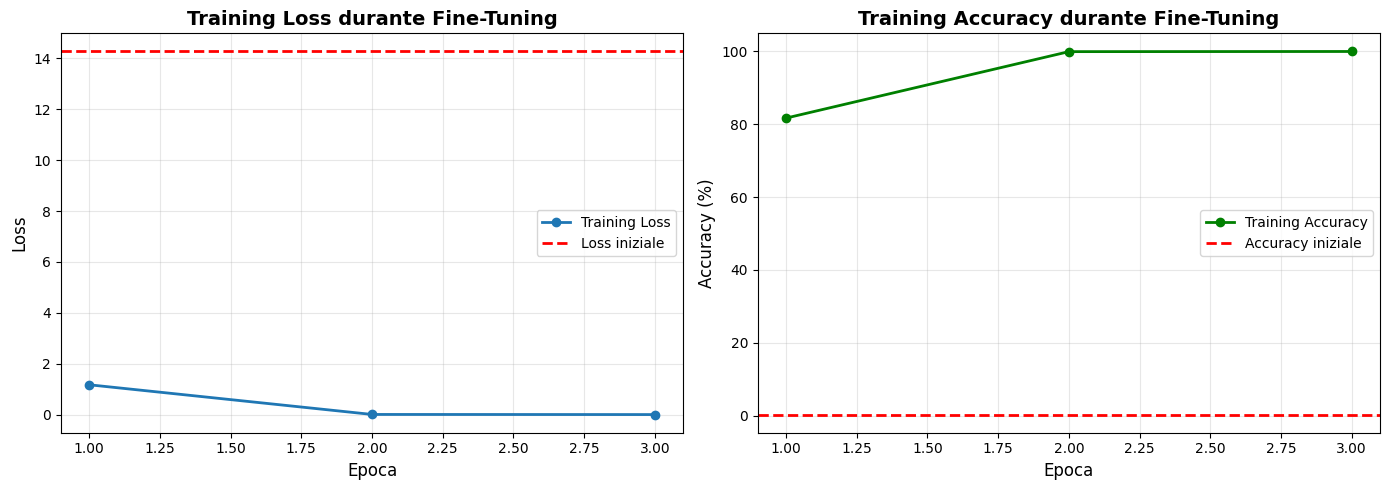

✓ Grafico salvato come 'finetuning_results.png'


In [33]:
# Grafico Loss e Accuracy durante training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico Loss
axes[0].plot(range(1, NUM_EPOCHS+1), training_losses, marker='o', linewidth=2, label='Training Loss')
axes[0].axhline(y=loss_before, color='r', linestyle='--', label='Loss iniziale', linewidth=2)
axes[0].set_xlabel('Epoca', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss durante Fine-Tuning', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Grafico Accuracy
axes[1].plot(range(1, NUM_EPOCHS+1), training_accuracies, marker='o', linewidth=2, color='green', label='Training Accuracy')
axes[1].axhline(y=accuracy_before, color='r', linestyle='--', label='Accuracy iniziale', linewidth=2)
axes[1].set_xlabel('Epoca', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training Accuracy durante Fine-Tuning', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('finetuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato come 'finetuning_results.png'")

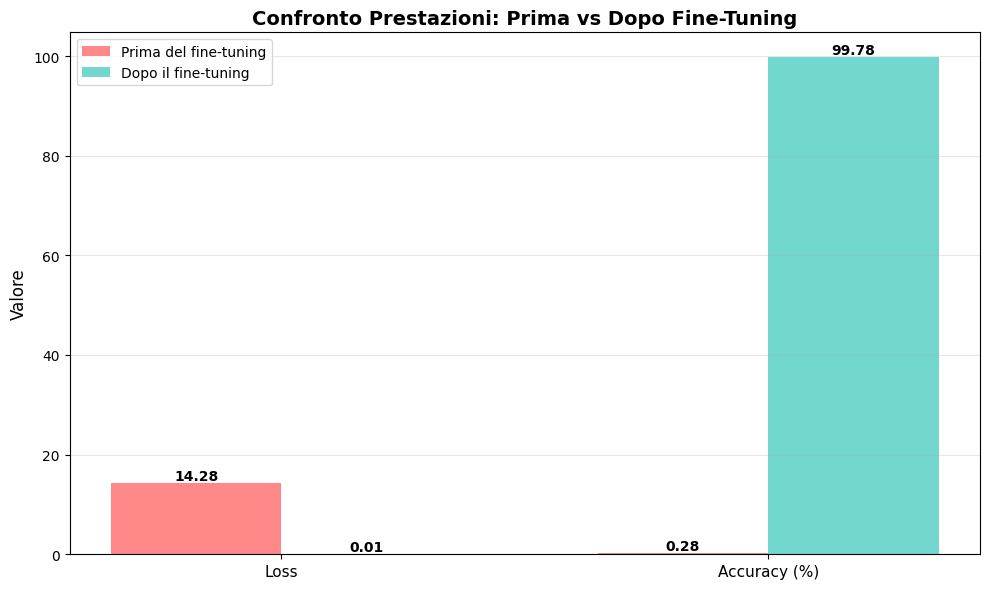

✓ Grafico di confronto salvato come 'comparison_results.png'


In [34]:
# Grafico comparativo Prima vs Dopo
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Loss', 'Accuracy (%)']
before_values = [loss_before, accuracy_before]
after_values = [loss_after, accuracy_after]

x = range(len(categories))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], before_values, width,
               label='Prima del fine-tuning', alpha=0.8, color='#FF6B6B')
bars2 = ax.bar([i + width/2 for i in x], after_values, width,
               label='Dopo il fine-tuning', alpha=0.8, color='#4ECDC4')

ax.set_ylabel('Valore', fontsize=12)
ax.set_title('Confronto Prestazioni: Prima vs Dopo Fine-Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)

# Aggiungi valori sopra le barre
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico di confronto salvato come 'comparison_results.png'")

## 💾 Step 11: Salvataggio Modello Fine-Tuned

Salviamo il modello fine-tuned per poterlo riutilizzare in futuro.

In [ ]:
# Path output
output_path = "resnet50_places365_finetuned.pth"

# Salva il modello con tutte le informazioni utili
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_before': loss_before,
    'loss_after': loss_after,
    'accuracy_before': accuracy_before,
    'accuracy_after': accuracy_after,
    'training_losses': training_losses,
    'training_accuracies': training_accuracies,
}, output_path)

print(f"✓ Modello salvato in '{output_path}'")
print(f"✓ Dimensione file: {os.path.getsize(output_path) / (1024**2):.2f} MB")

## 📝 Step 12: Riepilogo Finale

Ecco un riepilogo completo dell'esperimento.

In [ ]:
print("\n" + "="*60)
print("🎉 ESPERIMENTO COMPLETATO!")
print("="*60)
print()
print("📊 RIEPILOGO:")
print(f"  • Device utilizzato: {DEVICE}")
print(f"  • Numero di epoche: {NUM_EPOCHS}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"  • Batch size: {BATCH_SIZE}")
print()
print("📈 RISULTATI:")
print(f"  • Loss:     {loss_before:.4f} → {loss_after:.4f} ({loss_before - loss_after:+.4f})")
print(f"  • Accuracy: {accuracy_before:.2f}% → {accuracy_after:.2f}% ({accuracy_after - accuracy_before:+.2f}%)")
print()
print("💾 FILE GENERATI:")
print(f"  • {output_path} (modello fine-tuned)")
print(f"  • finetuning_results.png (grafici training)")
print(f"  • comparison_results.png (confronto risultati)")
print()
print("="*60)